In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet 

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

c:\Users\vbjb2\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
pjme = pd.read_csv('../Downloads/Fb_Prophet_Research/FUELMIX for a year.csv',
                   index_col=[0],
                   parse_dates=[0])
pjme.head()

,State,Fuel Type,Supply
DateTime,,,
2022-07-30,NSW,Battery,526.339
2022-07-30,NSW,Black coal,796231.000
2022-07-30,NSW,Gas,25571.898
2022-07-30,NSW,Hydro,60824.819
2022-07-30,NSW,Liquid Fuel,0.000


In [4]:
pjme = pjme[ pjme['Fuel Type'] == 'Black coal' ]
pjme.head()

,State,Fuel Type,Supply
DateTime,,,
2022-07-30,NSW,Black coal,796231.000
2022-07-30,QLD,Black coal,808768.335
2022-08-06,NSW,Black coal,954447.776
2022-08-06,QLD,Black coal,843923.152
2022-08-13,NSW,Black coal,872253.694


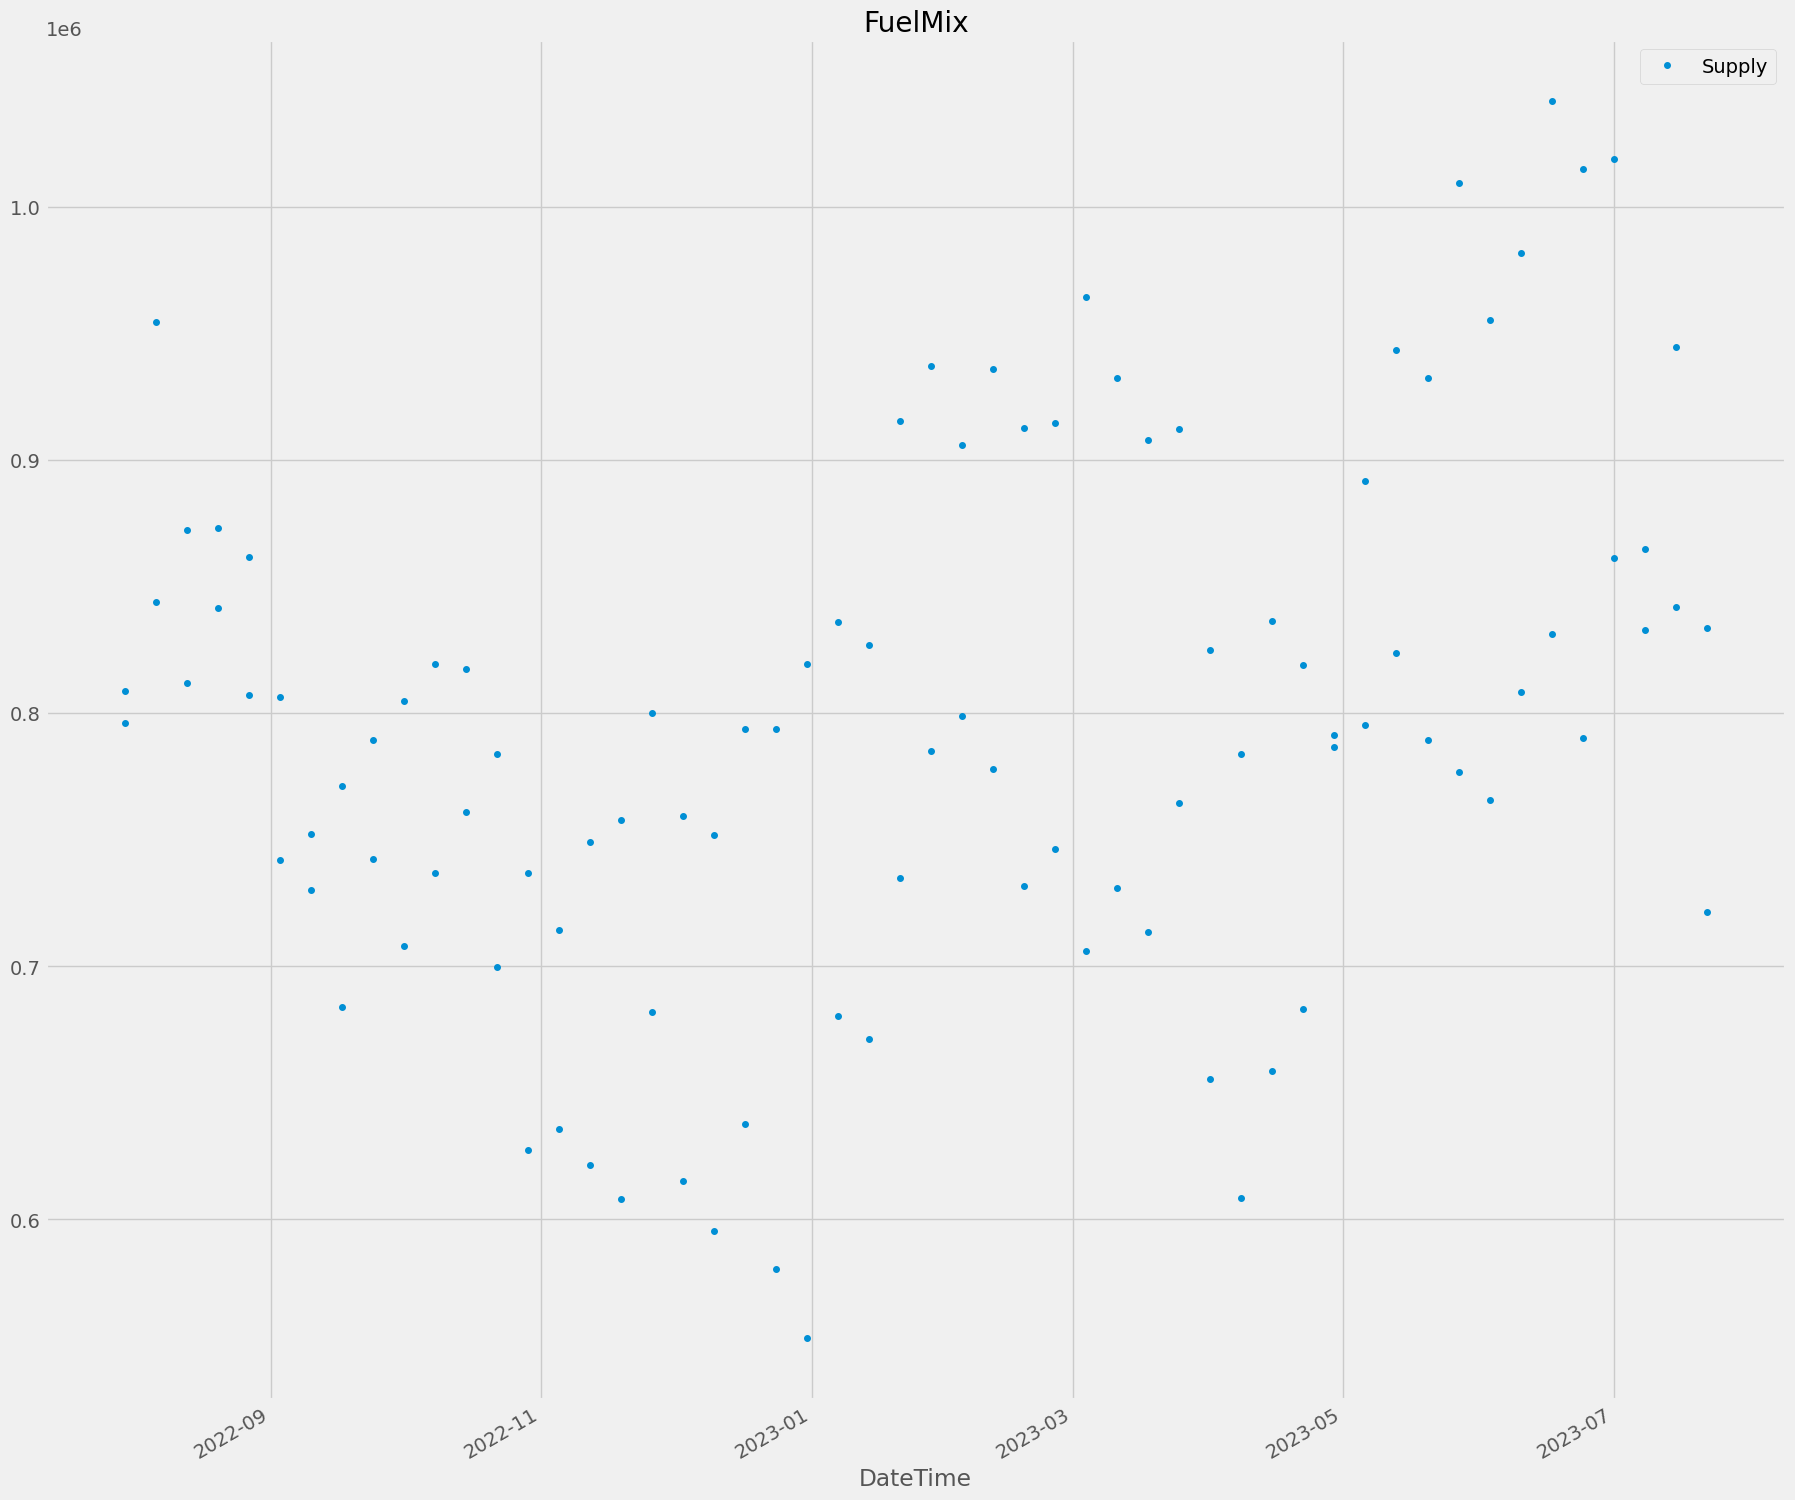

In [5]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(20,20),
          ms=8,
          title='FuelMix')
plt.show()

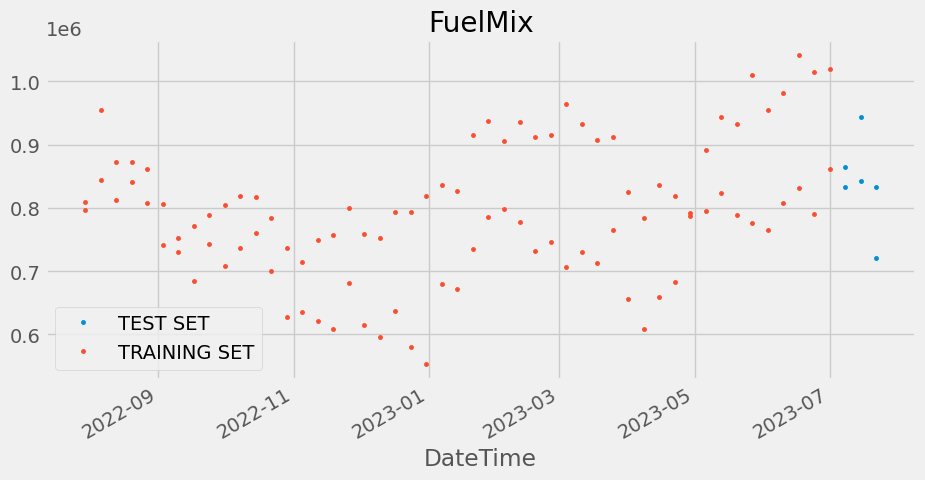

In [6]:
split_date = '01-July-2023'
pjme_train = pjme.loc[pjme.index <= split_date].copy()[['Supply']]
pjme_test = pjme.loc[pjme.index > split_date].copy()[['Supply']]

#Plot train and test so I can see where I have split
pjme_test \
    .rename(columns={'Supply': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'Supply': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='FuelMix', style='.', ms=5)
plt.show()

In [7]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'DateTime':'ds',
                     'Supply':'y'})

In [8]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

10:38:21 - cmdstanpy - INFO - Chain [1] start processing
10:38:21 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 172 ms
Wall time: 1.01 s


In [9]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'DateTime':'ds',
                     'Supply':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [10]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-07-08,879519.233326,755778.461469,9.861534e+05,879519.233326,879522.709249,0.0,0.0,0.0,0.0,0.0,0.0,879519.233326
1,2023-07-08,879519.233326,762139.025373,9.908441e+05,879466.386902,879585.453859,0.0,0.0,0.0,0.0,0.0,0.0,879519.233326
2,2023-07-15,883916.513172,771959.884985,1.007959e+06,883779.663102,884075.305453,0.0,0.0,0.0,0.0,0.0,0.0,883916.513172
3,2023-07-15,883916.513172,767352.097670,9.936732e+05,883655.267089,884203.035263,0.0,0.0,0.0,0.0,0.0,0.0,883916.513172
4,2023-07-22,888313.793017,776880.915274,1.005838e+06,887883.319958,888738.924562,0.0,0.0,0.0,0.0,0.0,0.0,888313.793017


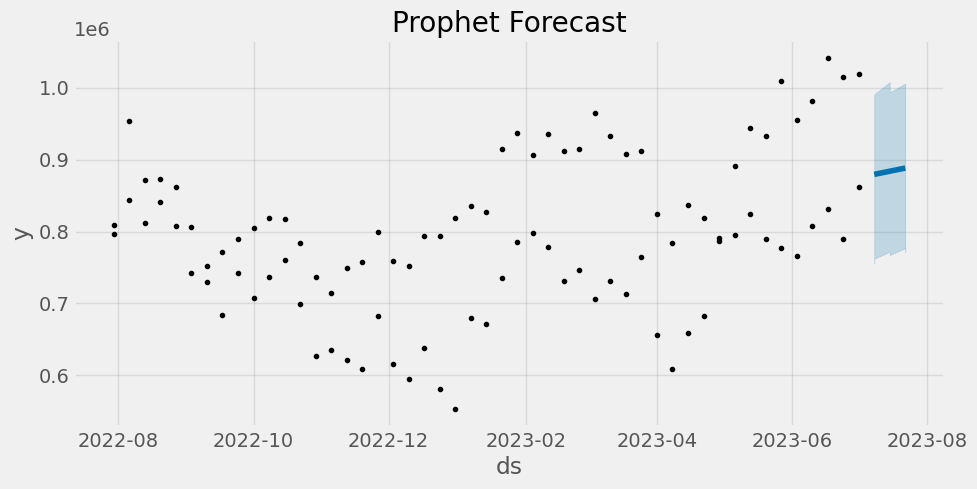

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

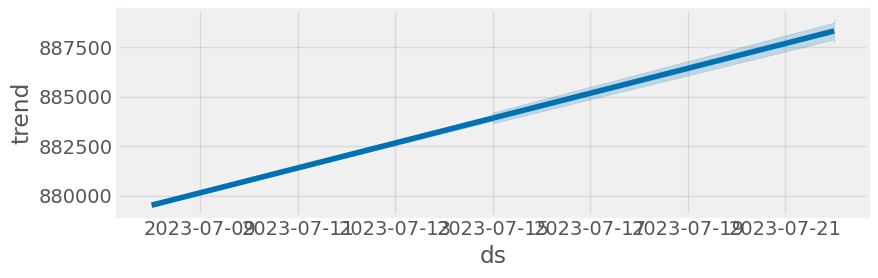

In [12]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

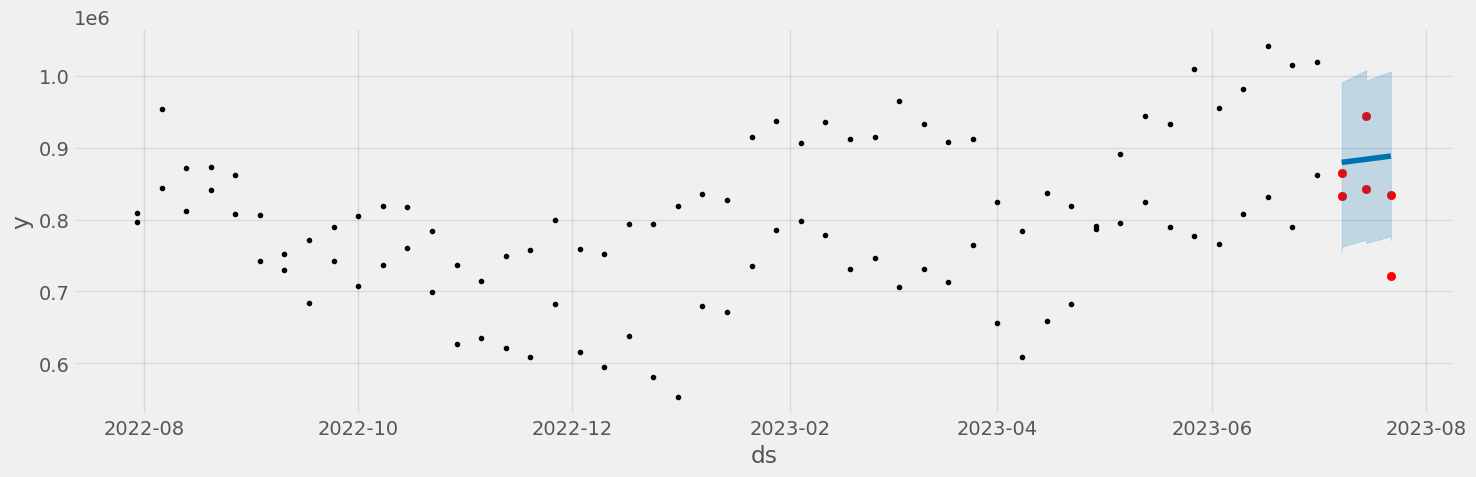

In [13]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['Supply'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

ConversionError: Failed to convert value(s) to axis units: '2022-08'

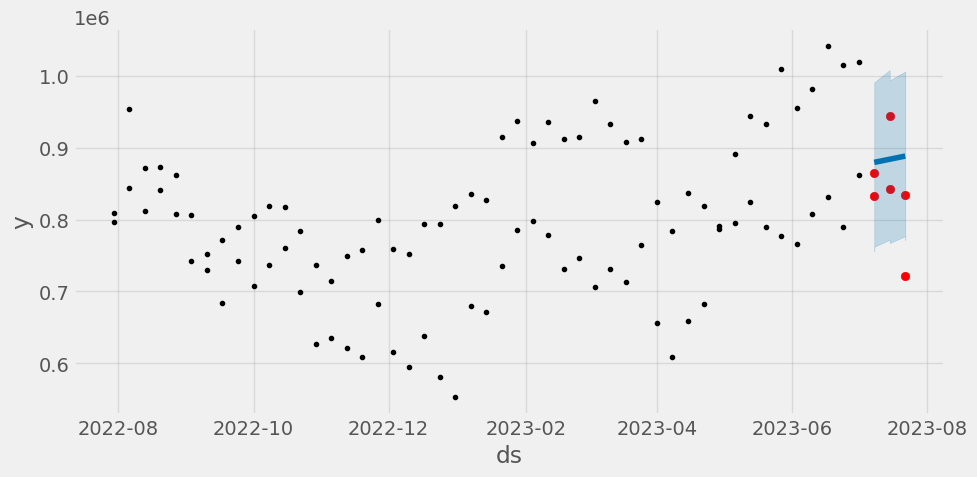

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['Supply'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='2022-08',
              upper='2023-08')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Forecast vs Actuals')

ConversionError: Failed to convert value(s) to axis units: '08-01-2022'

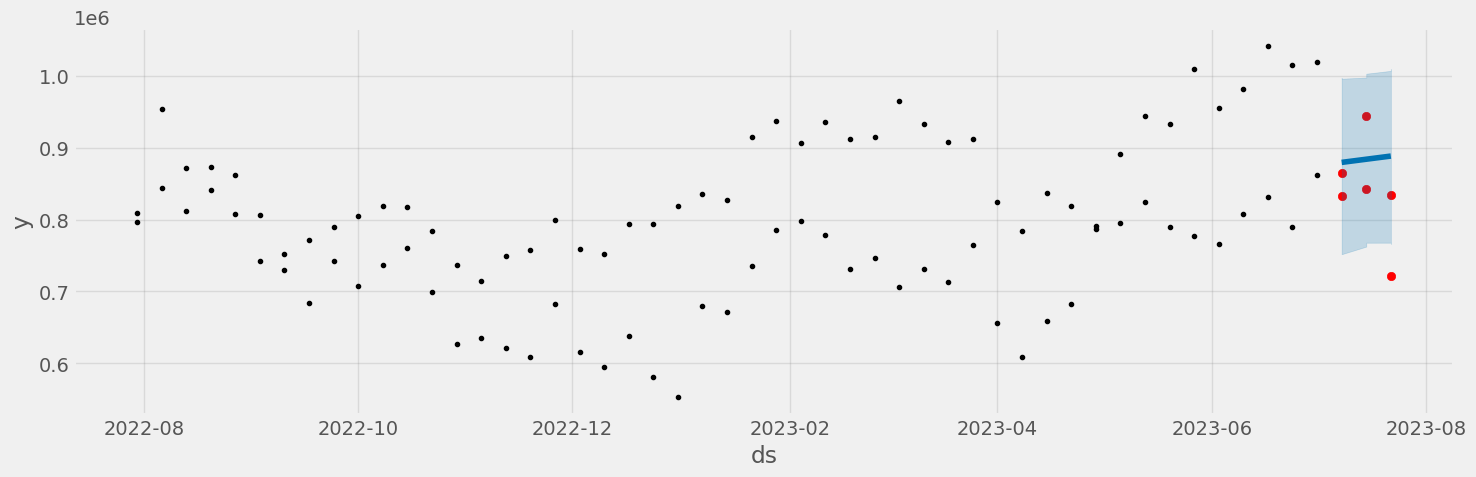

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['Supply'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='08-01-2022', upper='08-01-2023')
ax.set_ylim(0, 60000)
ax.set_title('Forecast vs Actuals2')
plt.show()

In [ ]:
mean_absolute_percentage_error(y_true=pjme_test['Supply'],
                   y_pred=pjme_test_fcst['yhat'])

8.0565689681091

In [ ]:
from pandas.tseries.holiday import (
    Holiday, AbstractHolidayCalendar, next_monday,
    MO, TU, FR, next_monday_or_tuesday,
    GoodFriday, EasterMonday
)

class VictorianHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1, observance=next_monday),
        Holiday("Australia Day", month=1, day=26, observance=next_monday),
        Holiday("Labour Day",
                month=3, day=1, offset=pd.DateOffset(weekday=MO(2))),     
        GoodFriday,
        EasterMonday,
        Holiday("ANZAC Day", month=4, day=25),
        Holiday("Queen's Birthday",
                month=6, day=1, offset=pd.DateOffset(weekday=MO(2))),
        # This one is hard to predict. Grand Final is traditionally last Sat in Sept but isn't always...
        Holiday("Friday before the AFL Grand Final",
                month=10, day=1, offset=pd.DateOffset(weekday=FR(-1))),
        Holiday("Melbourne Cup",
                month=11, day=1, offset=pd.DateOffset(weekday=TU(1))),
        Holiday("Christmas Day",
                month=12, day=25, observance=next_monday_or_tuesday),
        Holiday("Boxing Day", month=12, day=26,
                observance=next_monday_or_tuesday),
    ]
cal = AbstractHolidayCalendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [ ]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

09:43:42 - cmdstanpy - INFO - Chain [1] start processing
09:43:43 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 125 ms
Wall time: 700 ms


In [ ]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

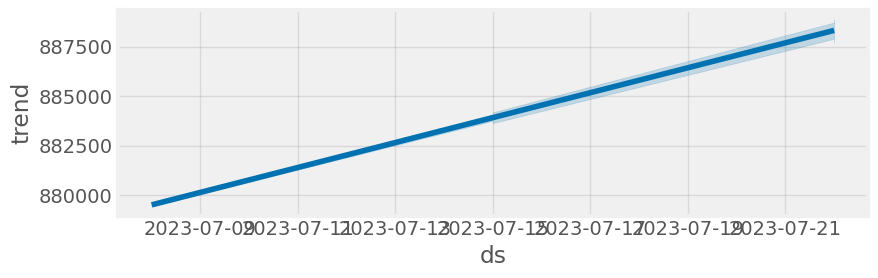

In [ ]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

ConversionError: Failed to convert value(s) to axis units: '2023-07'

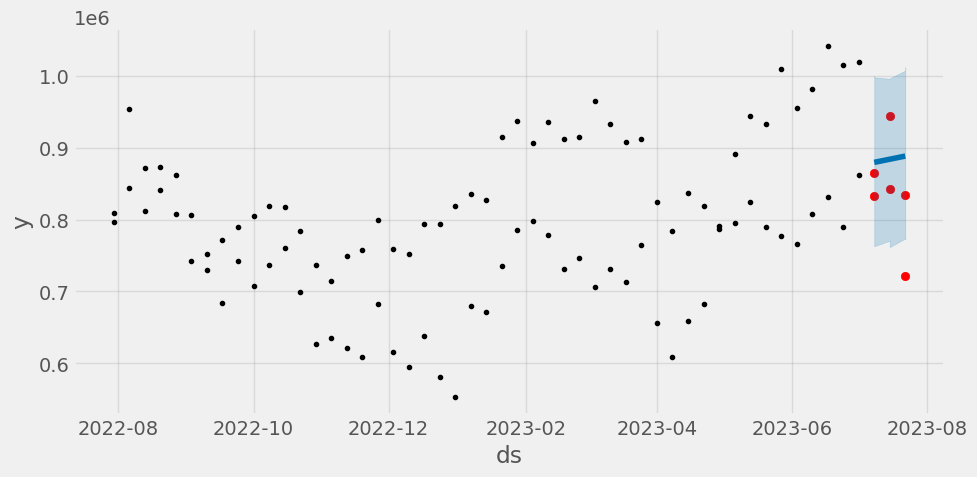

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['Supply'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='2023-07',
              upper='2023-08')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Predictions vs Actual')

In [ ]:
mean_absolute_percentage_error(y_true=pjme_test['Supply'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

8.0565689681091

In [ ]:
##No Holidays July-Aug

In [ ]:
#Rsme

In [ ]:
#Predict into the Future

In [ ]:
'''future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)'''



future = model.make_future_dataframe(periods=22, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [ ]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2023-07-01 01:00:00,875148.127765
1,2023-07-01 02:00:00,875174.302050
2,2023-07-01 03:00:00,875200.476335
3,2023-07-01 04:00:00,875226.650620
4,2023-07-01 05:00:00,875252.824905


In [ ]:
#Rsme
np.sqrt(mean_squared_error(y_true=pjme_test['Supply'],
                   y_pred=pjme_test_fcst['yhat']))

80199.3452506292

In [ ]:
#Cross Validation

In [ ]:
pjme.shape

(104, 3)

In [ ]:
104-22

82

In [21]:
from prophet.diagnostics import cross_validation
cv = cross_validation(model, initial='104 days', period='22 days', horizon = '30 days')

  0%|          | 0/10 [00:00<?, ?it/s]11:04:04 - cmdstanpy - INFO - Chain [1] start processing
11:04:04 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:07,  1.21it/s]11:04:04 - cmdstanpy - INFO - Chain [1] start processing
11:04:05 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:01<00:05,  1.47it/s]11:04:05 - cmdstanpy - INFO - Chain [1] start processing
11:04:05 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:01<00:03,  1.75it/s]11:04:05 - cmdstanpy - INFO - Chain [1] start processing
11:04:05 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:02<00:02,  2.01it/s]11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:02<00:02,  1.96it/s]11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 6/10 [00:03<00:02,  1.96it/s]11:04:07

In [22]:
cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-11-19,677370.625756,613232.838848,740727.634275,608168.591,2022-11-15
1,2022-11-19,677370.625756,606494.796171,742799.380884,757909.665,2022-11-15
2,2022-11-26,666214.179208,600808.799054,734362.862388,681882.947,2022-11-15
3,2022-11-26,666214.179208,598590.203281,732060.793003,799964.433,2022-11-15
4,2022-12-03,655057.732660,587830.396830,721430.078748,759392.566,2022-11-15


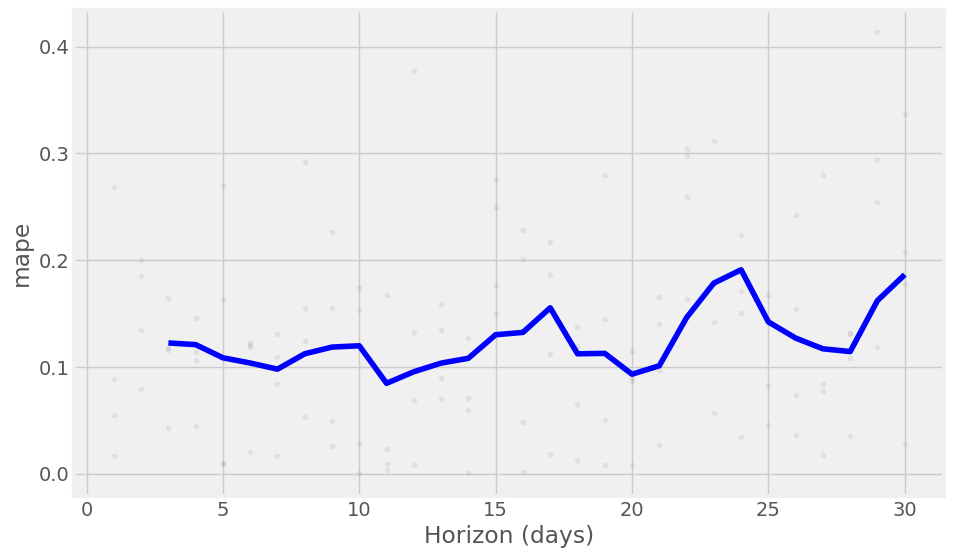

In [25]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv, metric='mape')

In [26]:
from prophet.diagnostics import performance_metrics
pm = performance_metrics(cv)
pm.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.353169e+10,116325.788429,97892.781672,0.122340,0.116367,0.128489,0.416667
1,4 days,9.821009e+09,99101.005781,90700.240454,0.120759,0.116367,0.122473,0.333333
2,5 days,8.495801e+09,92172.666927,77176.473218,0.108440,0.114642,0.105354,0.416667
3,6 days,7.872869e+09,88729.188231,74375.714400,0.103538,0.116167,0.099790,0.500000
4,7 days,7.983470e+09,89350.268319,72955.676817,0.097769,0.113764,0.094800,0.500000


In [27]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
RMSEs = []  # Store the RMSEs for each params here
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(pjme_train_prophet)  # Fit model with given params
    cv = cross_validation(model, initial='104', period='22 days', horizon = '5 days')
    p = performance_metrics(cv, rolling_window=1)
    RMSEs.append(p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = RMSEs
print(tuning_results)

11:18:59 - cmdstanpy - INFO - Chain [1] start processing
11:19:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/12 [00:00<?, ?it/s]11:19:00 - cmdstanpy - INFO - Chain [1] start processing
11:19:00 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  3.04it/s]11:19:01 - cmdstanpy - INFO - Chain [1] start processing
11:19:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:03,  3.17it/s]11:19:01 - cmdstanpy - INFO - Chain [1] start processing
11:19:01 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:02,  3.01it/s]11:19:01 - cmdstanpy - INFO - Chain [1] start processing
11:19:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:01<00:02,  2.96it/s]11:19:02 - cmdstanpy - INFO - Chain [1] start processing
11:19:02 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:01<00:02,  2.96it/s]11:19:02 - cmdstanpy - INFO - Chain [1] start processi

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  96337.300801
1                     0.001                     0.10  96337.300801
2                     0.001                     1.00  96337.300801
3                     0.001                    10.00  96337.300801
4                     0.010                     0.01  96337.300801
5                     0.010                     0.10  96337.300801
6                     0.010                     1.00  96337.300801
7                     0.010                    10.00  96337.300801
8                     0.100                     0.01  96337.300801
9                     0.100                     0.10  96337.300801
10                    0.100                     1.00  96337.300801
11                    0.100                    10.00  96337.300801
12                    0.500                     0.01  96337.300801
13                    0.500                     0.10  96337.30

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}
